In [2]:
# Install and load required packages
if (!require("httr")) install.packages("httr")
if (!require("jsonlite")) install.packages("jsonlite")
if (!require("tidyverse")) install.packages("tidyverse")
library(httr)
library(jsonlite)
library(tidyverse)

# Install and load required packages
if (!require("quantmod")) install.packages("quantmod")
if (!require("PerformanceAnalytics")) install.packages("PerformanceAnalytics")
library(quantmod)
library(PerformanceAnalytics)


In [3]:
# Function to get income statement data
get_income_statement <- function(symbol, api_key) {
  url <- paste0("https://www.alphavantage.co/query?",
                "function=INCOME_STATEMENT",
                "&symbol=", symbol,
                "&apikey=", api_key)

  response <- GET(url)
  data <- fromJSON(rawToChar(response$content))
  quarterly_reports <- data$quarterlyReports

  return(quarterly_reports)
}

# Function to get balance sheet data
get_balance_sheet <- function(symbol, api_key) {
  url <- paste0("https://www.alphavantage.co/query?",
                "function=BALANCE_SHEET",
                "&symbol=", symbol,
                "&apikey=", api_key)

  response <- GET(url)
  data <- fromJSON(rawToChar(response$content))
  quarterly_reports <- data$quarterlyReports

  return(quarterly_reports)
}

# Define your API key and symbol
api_key <- "4TK07IM3ZZKDYDEA"
symbol <- "AAPL"



In [4]:
# Get quarterly data
income_data <- get_income_statement(symbol, api_key)
balance_data <- get_balance_sheet(symbol, api_key)

# Process and calculate metrics
fundamental_data <- income_data %>%
  left_join(balance_data, by = "fiscalDateEnding") %>%
  mutate(
    ROE = as.numeric(netIncome) / as.numeric(totalShareholderEquity) * 100,
    DebtToEquity = as.numeric(totalLiabilities) / as.numeric(totalShareholderEquity),
    ProfitMargin = as.numeric(netIncome) / as.numeric(totalRevenue) * 100,
    Date = as.Date(fiscalDateEnding)
  ) %>%
  filter(Date >= as.Date("2023-01-01")) %>%
  arrange(Date)



Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `ProfitMargin = as.numeric(netIncome)/as.numeric(totalRevenue) *
  100`.
Caused by warning:
! NAs introduced by coercion”


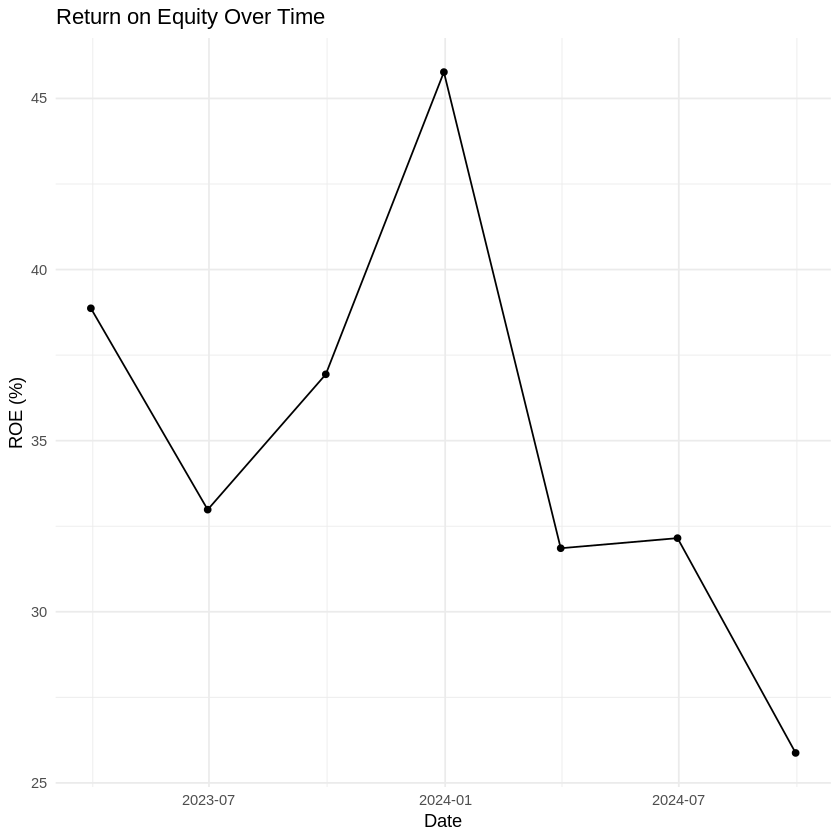

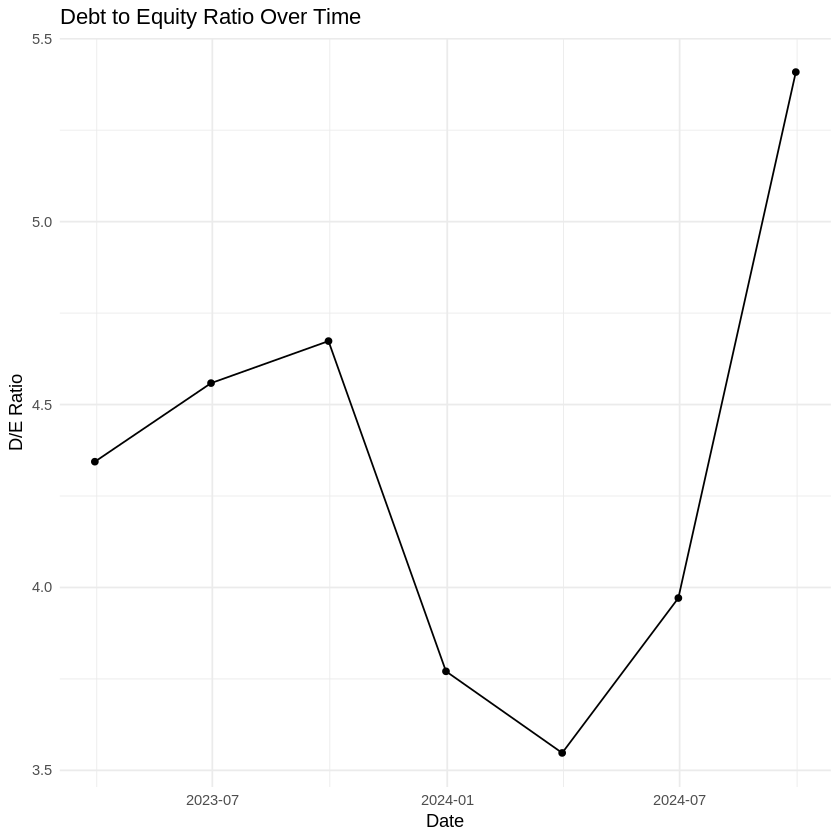

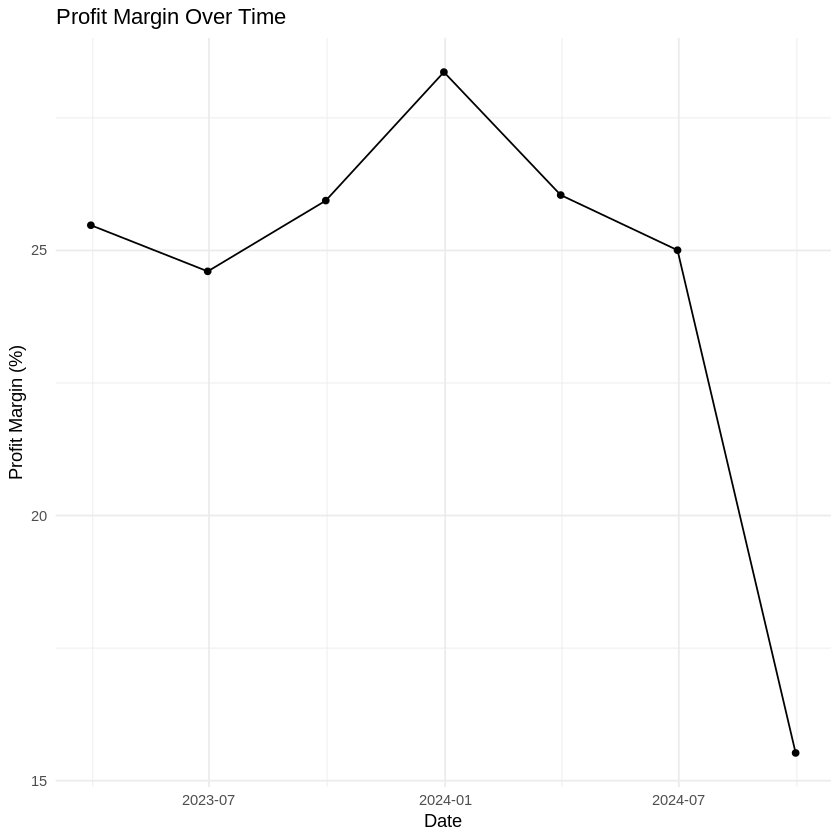

In [5]:
# Create time series visualizations
# ROE over time
ggplot(fundamental_data, aes(x = Date, y = ROE)) +
  geom_line() +
  geom_point() +
  theme_minimal() +
  labs(title = "Return on Equity Over Time",
       y = "ROE (%)",
       x = "Date")

# Debt to Equity over time
ggplot(fundamental_data, aes(x = Date, y = DebtToEquity)) +
  geom_line() +
  geom_point() +
  theme_minimal() +
  labs(title = "Debt to Equity Ratio Over Time",
       y = "D/E Ratio",
       x = "Date")

# Profit Margin over time
ggplot(fundamental_data, aes(x = Date, y = ProfitMargin)) +
  geom_line() +
  geom_point() +
  theme_minimal() +
  labs(title = "Profit Margin Over Time",
       y = "Profit Margin (%)",
       x = "Date")

# Save processed data
write.csv(fundamental_data, "fundamental_time_series.csv", row.names = FALSE)



In [6]:
# Display summary statistics
print("Summary Statistics:")
summary_stats <- fundamental_data %>%
  summarise(
    avg_ROE = mean(ROE, na.rm = TRUE),
    avg_DebtToEquity = mean(DebtToEquity, na.rm = TRUE),
    avg_ProfitMargin = mean(ProfitMargin, na.rm = TRUE),
    min_ROE = min(ROE, na.rm = TRUE),
    max_ROE = max(ROE, na.rm = TRUE)
  )
print(summary_stats)

[1] "Summary Statistics:"
   avg_ROE avg_DebtToEquity avg_ProfitMargin  min_ROE  max_ROE
1 34.92098         4.324883         24.42239 25.87533 45.77058


[1] "Quarterly Technical Metrics:"
# A tibble: 8 × 9
  Quarter End_Date   Price  MA10  MA20   RSI Volatility Sharpe  Beta
  <chr>   <date>     <dbl> <dbl> <dbl> <dbl>      <dbl>  <dbl> <dbl>
1 2023-Q1 2023-03-31  165.  160.  156.  70.4      0.245   3.96 1.15 
2 2023-Q2 2023-06-30  194.  187.  184.  77.6      0.184   3.58 1.21 
3 2023-Q3 2023-09-29  171.  174.  177.  38.2      0.212  -2.34 1.22 
4 2023-Q4 2023-12-29  193.  195.  194.  51.1      0.155   2.97 0.850
5 2024-Q1 2024-03-28  171.  173.  173.  42.4      0.210  -2.27 0.988
6 2024-Q2 2024-06-28  211.  212.  206.  61.7      0.274   3.07 1.28 
7 2024-Q3 2024-09-30  233   226.  224.  64.9      0.233   1.74 0.970
8 2024-Q4 2024-12-13  248.  245.  238.  75.5      0.174   1.69 0.670


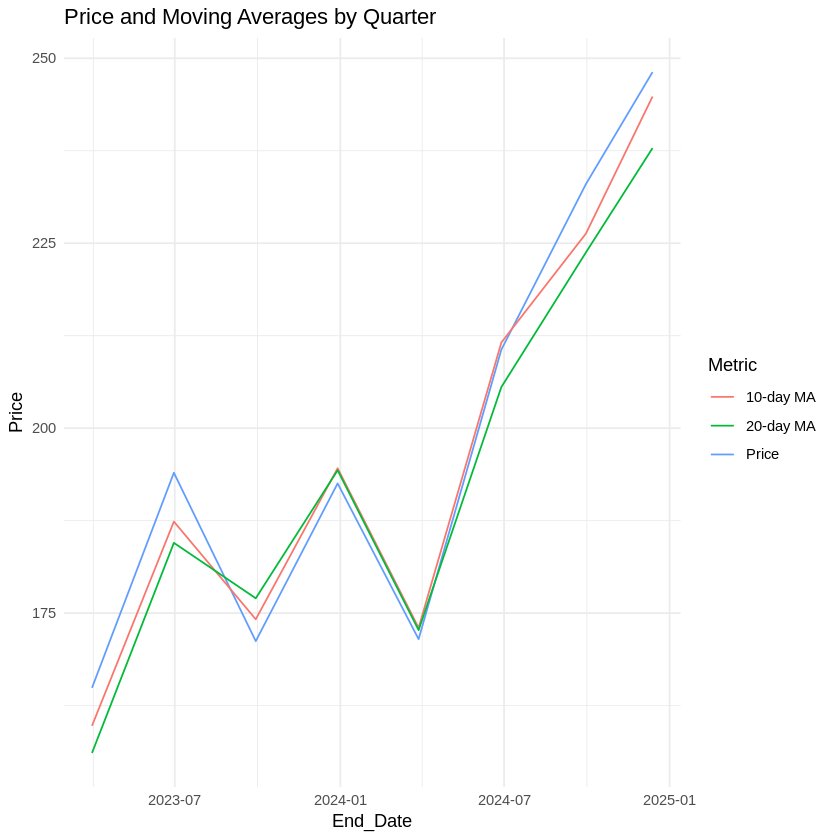

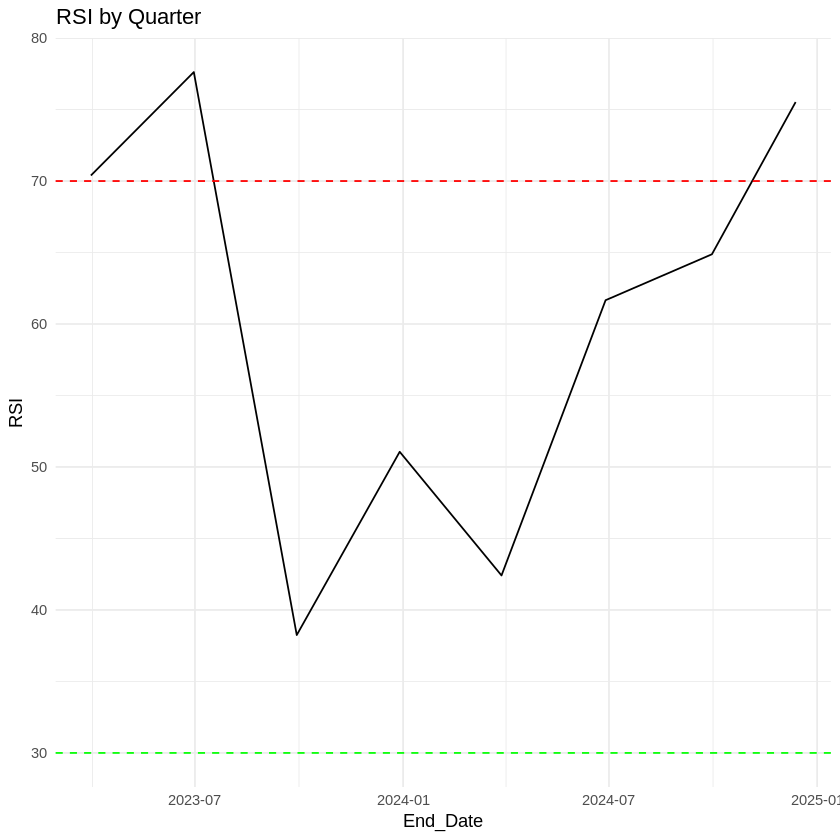

[1] "\nSummary Statistics:"
# A tibble: 1 × 5
  avg_price avg_rsi avg_beta avg_sharpe avg_volatility
      <dbl>   <dbl>    <dbl>      <dbl>          <dbl>
1      198.    60.2     1.04       1.55          0.211


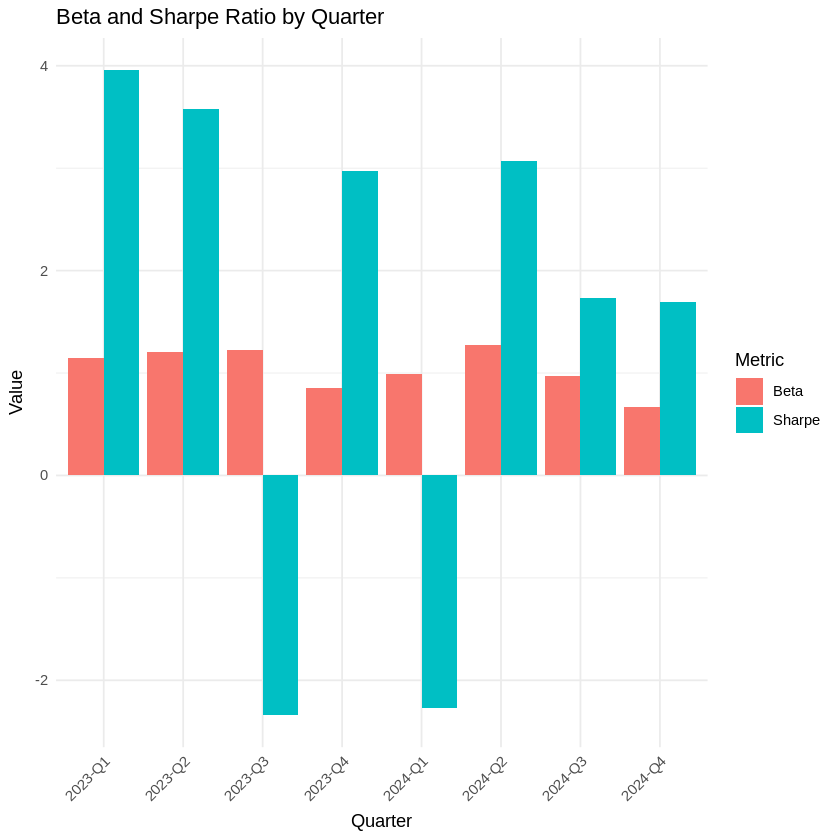

In [9]:


# Get stock data
symbol <- "AAPL"
market_symbol <- "^GSPC"  # S&P 500 for beta calculation

# Get YTD data (2024)
stock_data <- getSymbols(symbol,
                        from = "2023-01-01",
                        to = Sys.Date(),
                        auto.assign = FALSE)

market_data <- getSymbols(market_symbol,
                         from = "2023-01-01",
                         to = Sys.Date(),
                         auto.assign = FALSE)
# Calculate daily returns
stock_returns <- dailyReturn(stock_data)
market_returns <- dailyReturn(market_data)

# Function to calculate quarterly metrics
calculate_quarterly_metrics <- function(stock_data, stock_returns, market_returns) {
  # Convert xts to dataframe
  data_df <- data.frame(
    Date = index(stock_data),
    Price = as.numeric(Cl(stock_data)),
    Returns = as.numeric(stock_returns),
    Market_Returns = as.numeric(market_returns)
  )

  # Add technical indicators
  data_df$MA10 <- as.numeric(SMA(Cl(stock_data), n = 10))
  data_df$MA20 <- as.numeric(SMA(Cl(stock_data), n = 20))
  data_df$RSI <- as.numeric(RSI(Cl(stock_data), n = 14))

  # Convert to quarterly data
  quarterly_data <- data_df %>%
    mutate(Quarter = paste0(year(Date), "-Q", quarter(Date))) %>%
    group_by(Quarter) %>%
    summarise(
      End_Date = last(Date),
      Price = last(Price),
      MA10 = last(MA10),
      MA20 = last(MA20),
      RSI = last(RSI),
      Volatility = sd(Returns, na.rm = TRUE) * sqrt(252),  # Annualized volatility
      # Calculate quarterly Sharpe Ratio (assuming risk-free rate of 2%)
      Sharpe = (mean(Returns, na.rm = TRUE) - 0.02/252) / (sd(Returns, na.rm = TRUE)) * sqrt(252),
      # Calculate quarterly Beta
      Beta = cov(Returns, Market_Returns, use = "complete.obs") / var(Market_Returns, use = "complete.obs")
    )

  return(quarterly_data)
}

# Calculate quarterly metrics
quarterly_metrics <- calculate_quarterly_metrics(stock_data, stock_returns, market_returns)

# Display results
print("Quarterly Technical Metrics:")
print(quarterly_metrics)

# Save to CSV
write.csv(quarterly_metrics, "technical_metrics_quarterly.csv", row.names = FALSE)

# Create visualizations
# 1. Price and Moving Averages
ggplot(quarterly_metrics, aes(x = End_Date)) +
  geom_line(aes(y = Price, color = "Price")) +
  geom_line(aes(y = MA10, color = "10-day MA")) +
  geom_line(aes(y = MA20, color = "20-day MA")) +
  theme_minimal() +
  labs(title = "Price and Moving Averages by Quarter",
       y = "Price",
       color = "Metric")

# 2. RSI
ggplot(quarterly_metrics, aes(x = End_Date, y = RSI)) +
  geom_line() +
  geom_hline(yintercept = 70, linetype = "dashed", color = "red") +
  geom_hline(yintercept = 30, linetype = "dashed", color = "green") +
  theme_minimal() +
  labs(title = "RSI by Quarter",
       y = "RSI")

# 3. Beta and Sharpe Ratio
quarterly_metrics_long <- quarterly_metrics %>%
  select(Quarter, Beta, Sharpe) %>%
  pivot_longer(-Quarter, names_to = "Metric", values_to = "Value")

ggplot(quarterly_metrics_long, aes(x = Quarter, y = Value, fill = Metric)) +
  geom_bar(stat = "identity", position = "dodge") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Beta and Sharpe Ratio by Quarter",
       y = "Value")

# Calculate summary statistics
summary_stats <- quarterly_metrics %>%
  summarise(
    avg_price = mean(Price),
    avg_rsi = mean(RSI),
    avg_beta = mean(Beta),
    avg_sharpe = mean(Sharpe),
    avg_volatility = mean(Volatility)
  )

print("\nSummary Statistics:")
print(summary_stats)

In [13]:
# Read the CSV files
fundamental_data <- read.csv("fundamental_time_series.csv")
technical_data <- read.csv("technical_metrics_quarterly.csv")

# Create an ID column in both datasets (assuming they should match by row order)
fundamental_data <- fundamental_data %>%
  mutate(ID = row_number())

technical_data <- technical_data %>%
  mutate(ID = row_number())

# Join and clean datasets
combined_data <- fundamental_data %>%
  left_join(technical_data, by = "ID")

# Clean up and organize columns
final_data <- combined_data %>%
  select(
    ID,
    Date,
    Quarter,
    # Fundamental metrics
    ROE,
    DebtToEquity,
    ProfitMargin,
    # Technical metrics
    Price,
    MA10,
    MA20,
    RSI,
    Beta,
    Sharpe,
    Volatility
  ) %>%
  arrange(Date)

# Save combined dataset
write.csv(final_data, "combined_metrics_quarterly.csv", row.names = FALSE)